In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
import scipy.io
from scipy import signal as sig
def better_power_spectrum(signal, dt):
    freqs, psd = sig.welch(signal, fs=1/dt, nperseg=min(len(signal)//4, 256))   
    # Plot on log scale
    plt.semilogy(freqs, psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (log scale)')
    # plt.ylim(1e-3,1e-2)
    plt.grid(True, alpha=0.3)
    plt.show()

In [4]:
# head_data = scipy.io.loadmat('/Volumes/Lenovo/neuron_ablations/hb_dynamics/N2.mat')['N2_hb_dynamics']
head_data = scipy.io.loadmat('/Users/hengzhang/projects/WormSim/neuron_ablations_backup/hb_dynamics/N2.mat')['N2_hb_dynamics']

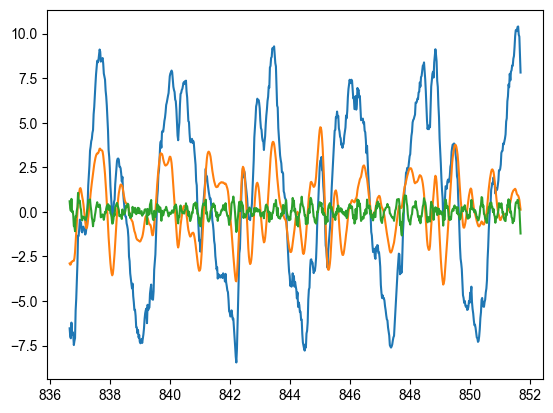

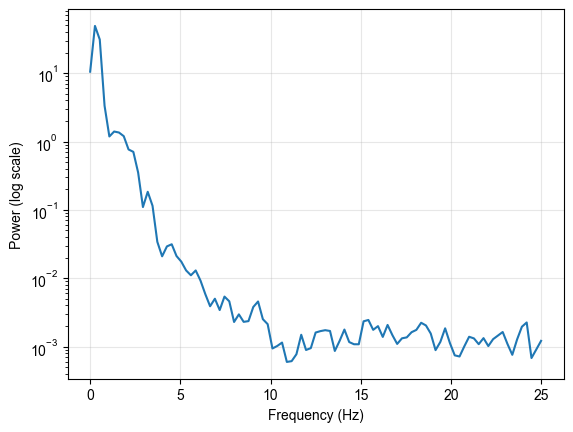

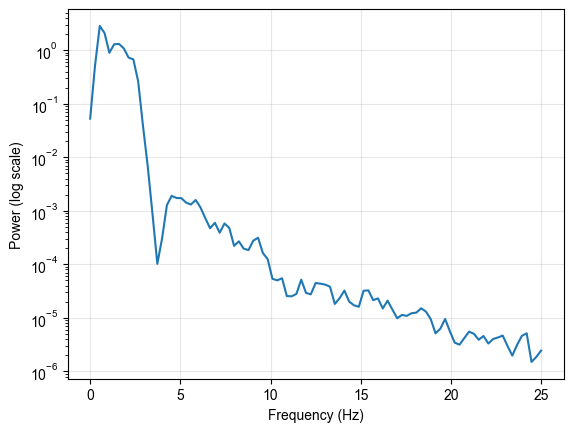

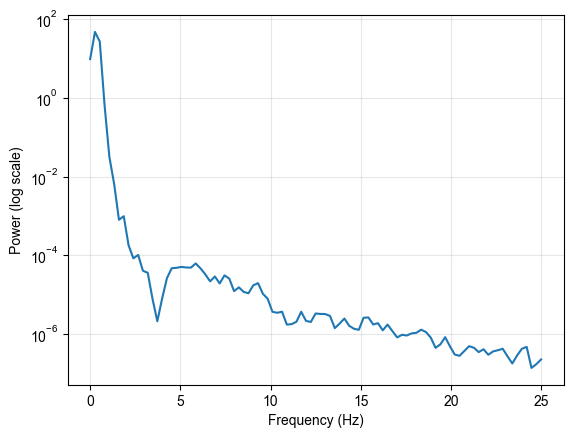

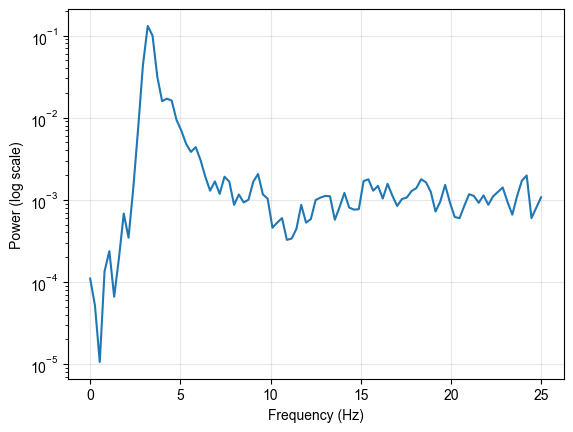

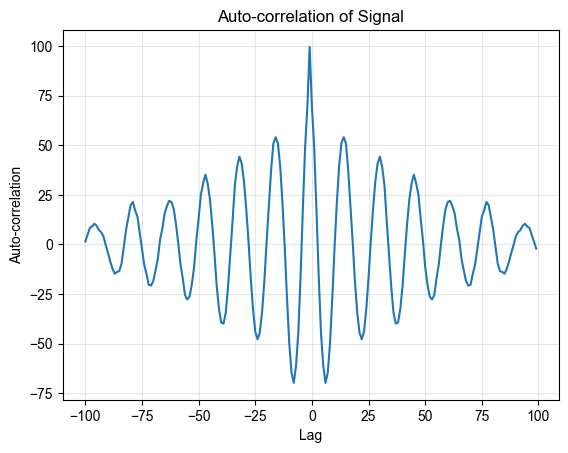

In [14]:
data_i = head_data[101,0]
plt.plot(data_i[:,0],data_i[:,1])
plt.plot(data_i[:,0],data_i[:,2] )
plt.plot(data_i[:,0],data_i[:,1] - data_i[:,2] - data_i[:,3])

plt.show()
better_power_spectrum(data_i[:,1] ,2/100)
better_power_spectrum(data_i[:,2] ,2/100)
better_power_spectrum(data_i[:,3],2/100)
better_power_spectrum(data_i[:,1] - data_i[:,2] - data_i[:,3] ,2/100)

s = data_i[:,1] - data_i[:,2] - data_i[:,3]
auto_corr = np.correlate(s, s, mode='full')
lags = np.arange(-100, 100)
plt.plot(lags, auto_corr[len(s)-100:len(s)+100])
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('Auto-correlation of Signal')
plt.grid(True, alpha=0.3)
plt.show()


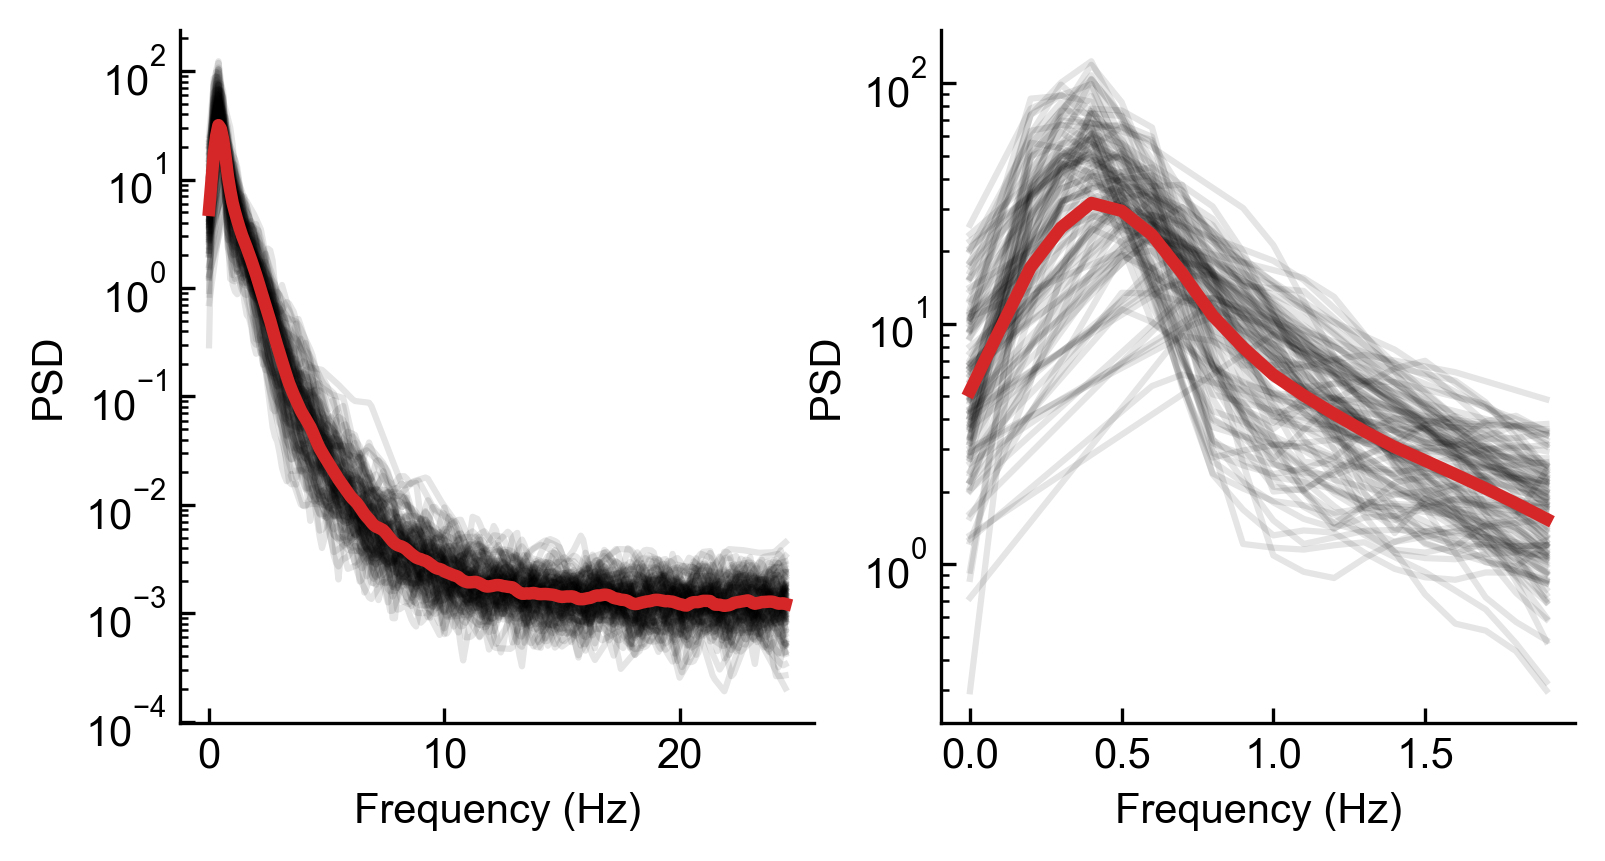

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy.interpolate import interp1d
from scipy.stats import sem

def average_spectrum_variable_length_interpolation(time_series_list, dt_list, target_freq_resolution=None, method='arithmetic'):
    """
    Average spectra from time series of different lengths using interpolation.
    
    Parameters:
    time_series_list: list of 1D arrays with potentially different lengths
    dt_list: list of time steps for each time series (or single dt if all same)
    target_freq_resolution: desired frequency resolution (Hz), if None, use finest resolution
    """
    # Handle single dt case
    if not isinstance(dt_list, list):
        dt_list = [dt_list] * len(time_series_list)
    
    # Calculate spectra for each time series
    all_freqs = []
    all_psds = []
    
    for i, (signal, dt) in enumerate(zip(time_series_list, dt_list)):
        # Calculate power spectral density using Welch's method
        freqs, psd = sig.welch(signal, fs=1/dt, nperseg=min(len(signal)//4, 256))
        all_freqs.append(freqs)
        all_psds.append(psd)
    
    # Determine common frequency grid
    if target_freq_resolution is None:
        # Use the finest frequency resolution available
        min_df = min([freqs[1] - freqs[0] for freqs in all_freqs])
        max_freq = min([freqs[-1] for freqs in all_freqs])  # Use minimum Nyquist frequency
        target_freqs = np.arange(0, max_freq, min_df)
    else:
        max_freq = min([freqs[-1] for freqs in all_freqs])
        target_freqs = np.arange(0, max_freq, target_freq_resolution)
    
    # Interpolate all spectra to common frequency grid
    interpolated_psds = []
    
    for freqs, psd in zip(all_freqs, all_psds):
        # Only interpolate within the valid frequency range
        valid_mask = target_freqs <= freqs[-1]
        target_freqs_valid = target_freqs[valid_mask]
        
        # Linear interpolation in log space (better for power spectra)
        log_psd = np.log10(psd + 1e-12)  # Add small value to avoid log(0)
        interpolator = interp1d(freqs, log_psd, kind='linear', 
                              bounds_error=False, fill_value='extrapolate')
        
        log_psd_interp = interpolator(target_freqs_valid)
        psd_interp = 10**log_psd_interp
        
        # Pad with NaN for frequencies beyond this signal's range
        psd_full = np.full(len(target_freqs), np.nan)
        psd_full[valid_mask] = psd_interp
        
        interpolated_psds.append(psd_full)
    
    
    # Calculate average and standard deviation based on the specified method
    if method == 'algorithmic':
        # Algorithmic mean and standard deviation
        avg_psd = np.nanmean(interpolated_psds, axis=0)
        std_err = np.nanstd(interpolated_psds, axis=0)
    elif method == 'geometric':
        # Geometric mean and standard deviation
        log_psds = [np.log(interpolated_psd + 1e-12)  # Add small value to avoid log(0)
                    for interpolated_psd in interpolated_psds]
        avg_psd = np.exp(np.nanmean(log_psds, axis=0))
        std_err = np.nanstd(log_psds, axis=0)
    else:
        raise ValueError("Invalid method specified. Choose 'algorithmic' or 'geometric'.")
    
    # Count the number of valid (non-NaN) entries for each frequency
    n_valid = np.sum(~np.isnan(interpolated_psds), axis=0)
    
    return target_freqs, avg_psd, std_err, interpolated_psds, n_valid



head_curv_ls = []
for i in range(len(head_data)):
    head_curv_ls.append(head_data[i,0][:,1])

target_freqs, avg_psd, std_err, interpolated_psds, n_valid = average_spectrum_variable_length_interpolation(head_curv_ls,2/100,0.1,method='geometric')
# plt.fill_between(target_freqs, avg_psd - std_err, avg_psd + std_err, alpha=0.3)
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=300)
for i in range(len(interpolated_psds)):
    ax[0].semilogy(target_freqs, interpolated_psds[i],'k',alpha=0.1)
ax[0].semilogy(target_freqs, avg_psd,'tab:red',linewidth=3)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('PSD')
for i in range(len(interpolated_psds)):
    ax[1].semilogy(target_freqs[:20], interpolated_psds[i][:20],'k',alpha=0.1)
ax[1].semilogy(target_freqs[:20],avg_psd[:20],'tab:red',linewidth=3)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD')
plt.savefig('Fig1/Fig1_spectrum_plot.pdf')






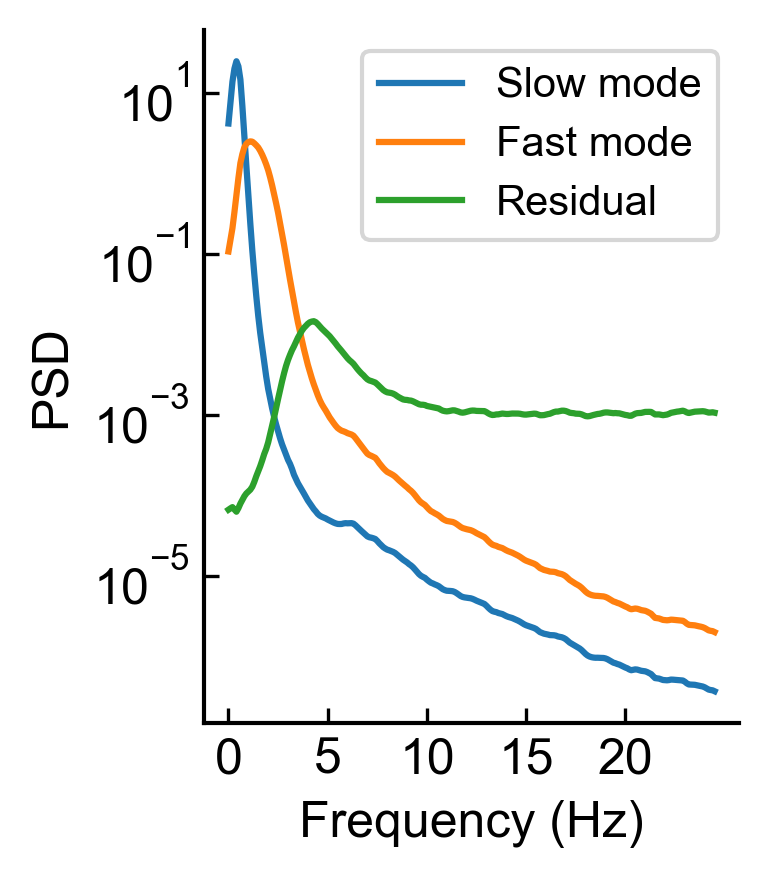

In [33]:
slow_mode_ls = []
fast_mode_ls = []
res_mode_ls = []
for i in range(len(head_data)):
    slow_mode_ls.append(head_data[i,0][:,3])
    fast_mode_ls.append(head_data[i,0][:,2])
    res_mode_ls.append(head_data[i,0][:,1] - head_data[i,0][:,2] - head_data[i,0][:,3])

target_freqs, slow_avg_psd, _, _, _ = average_spectrum_variable_length_interpolation(slow_mode_ls,2/100,0.1,method='geometric')
target_freqs, fast_avg_psd, _, _, _ = average_spectrum_variable_length_interpolation(fast_mode_ls,2/100,0.1,method='geometric')
target_freqs, res_avg_psd, _, _, _ = average_spectrum_variable_length_interpolation(res_mode_ls,2/100,0.1,method='geometric')

fig,ax = plt.subplots(1,1,figsize=(2.3,3),dpi=300)
ax.semilogy(target_freqs,slow_avg_psd,label='Slow mode')
ax.semilogy(target_freqs,fast_avg_psd,label='Fast mode')
ax.semilogy(target_freqs,res_avg_psd,label='Residual')
ax.set_xlabel('Frequency (Hz)',fontsize=12)
ax.set_ylabel('PSD',fontsize=12)
ax.set_xticks([0,5,10,15,20])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()
plt.setp(ax.spines.values(), linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('Fig1/Fig1_modes_spectrum_plot.pdf')








In [34]:
print('slow peak frequency: ',target_freqs[np.argmax(slow_avg_psd)])
print('fast peak frequency: ',target_freqs[np.argmax(fast_avg_psd)])
print('residual peak frequency: ',target_freqs[np.argmax(res_avg_psd)])

slow peak frequency:  0.4
fast peak frequency:  1.1
residual peak frequency:  4.3
